Name: Xiang Li
NetID: xl649

In [17]:
#imports
import cv2
import numpy as np
import glob
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def calibrate_camera(check_board_dim, image_path):
    # Defining the dimensions of checkerboard
    CHECKERBOARD = check_board_dim
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Creating vector to store vectors of 3D points for each checkerboard image
    objpoints = []
    # Creating vector to store vectors of 2D points for each checkerboard image
    imgpoints = []

    # Defining the world coordinates for 3D points
    objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[0, :, :2] = np.mgrid[0:CHECKERBOARD[0],
                              0:CHECKERBOARD[1]].T.reshape(-1, 2)
    prev_img_shape = None

    # Extracting path of individual image stored in a given directory
    images = glob.glob(image_path)
    for fname in images:
        print('processing img {}'.format(fname))
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chess board corners
        # If desired number of corners are found in the image then ret = true
        ret, corners = cv2.findChessboardCorners(
            gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

        """
        If desired number of corner are detected,
        we refine the pixel coordinates and display
        them on the images of checker board
        """
        if ret == True:
            print("corner detected")
            objpoints.append(objp)
            # refining pixel coordinates for given 2d points.
            corners2 = cv2.cornerSubPix(
                gray, corners, (11, 11), (-1, -1), criteria)

            imgpoints.append(corners2)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)

        # cv2.imshow('img',img)
        cv2.waitKey(0)

    cv2.destroyAllWindows()

    h, w = img.shape[:2]

    """
    Performing camera calibration by
    passing the value of known 3D points (objpoints)
    and corresponding pixel coordinates of the
    detected corners (imgpoints)
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None)

    print("Camera matrix : \n")
    print(mtx)
    print("dist : \n")
    print(dist)
    print("rvecs : \n")
    print(rvecs)
    print("tvecs : \n")
    print(tvecs)
    return ret, mtx, dist, rvecs, tvecs

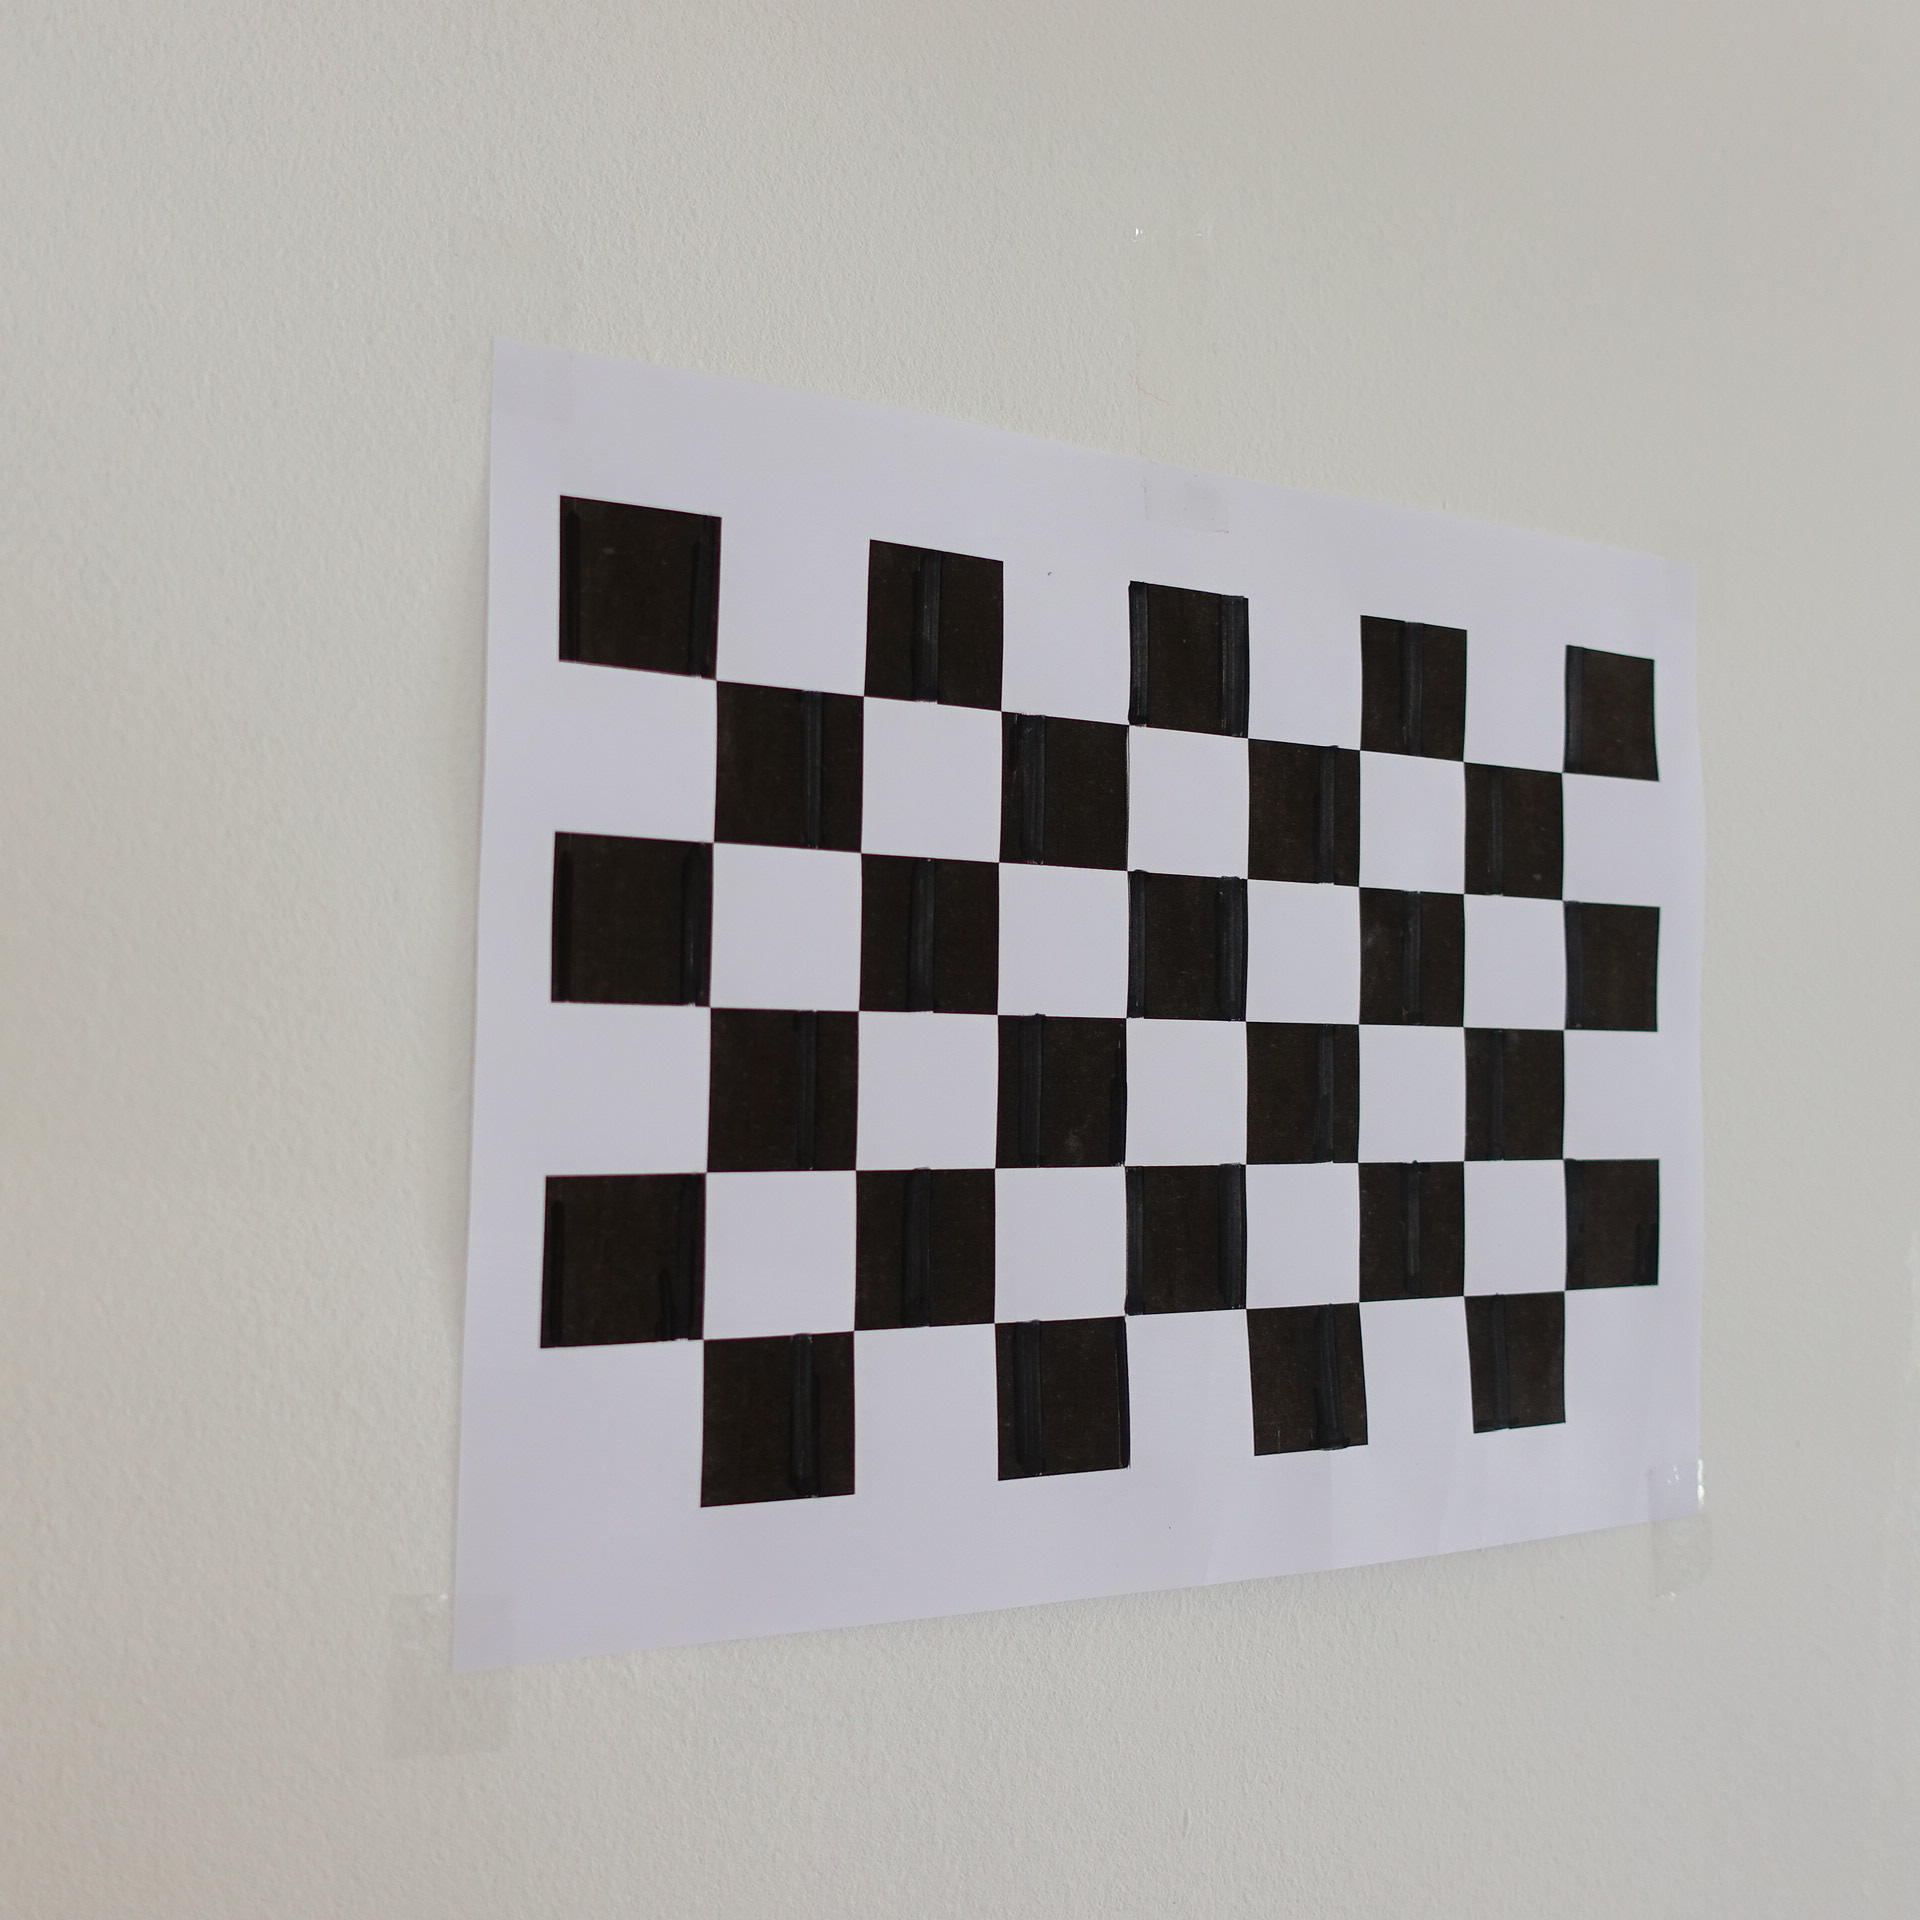

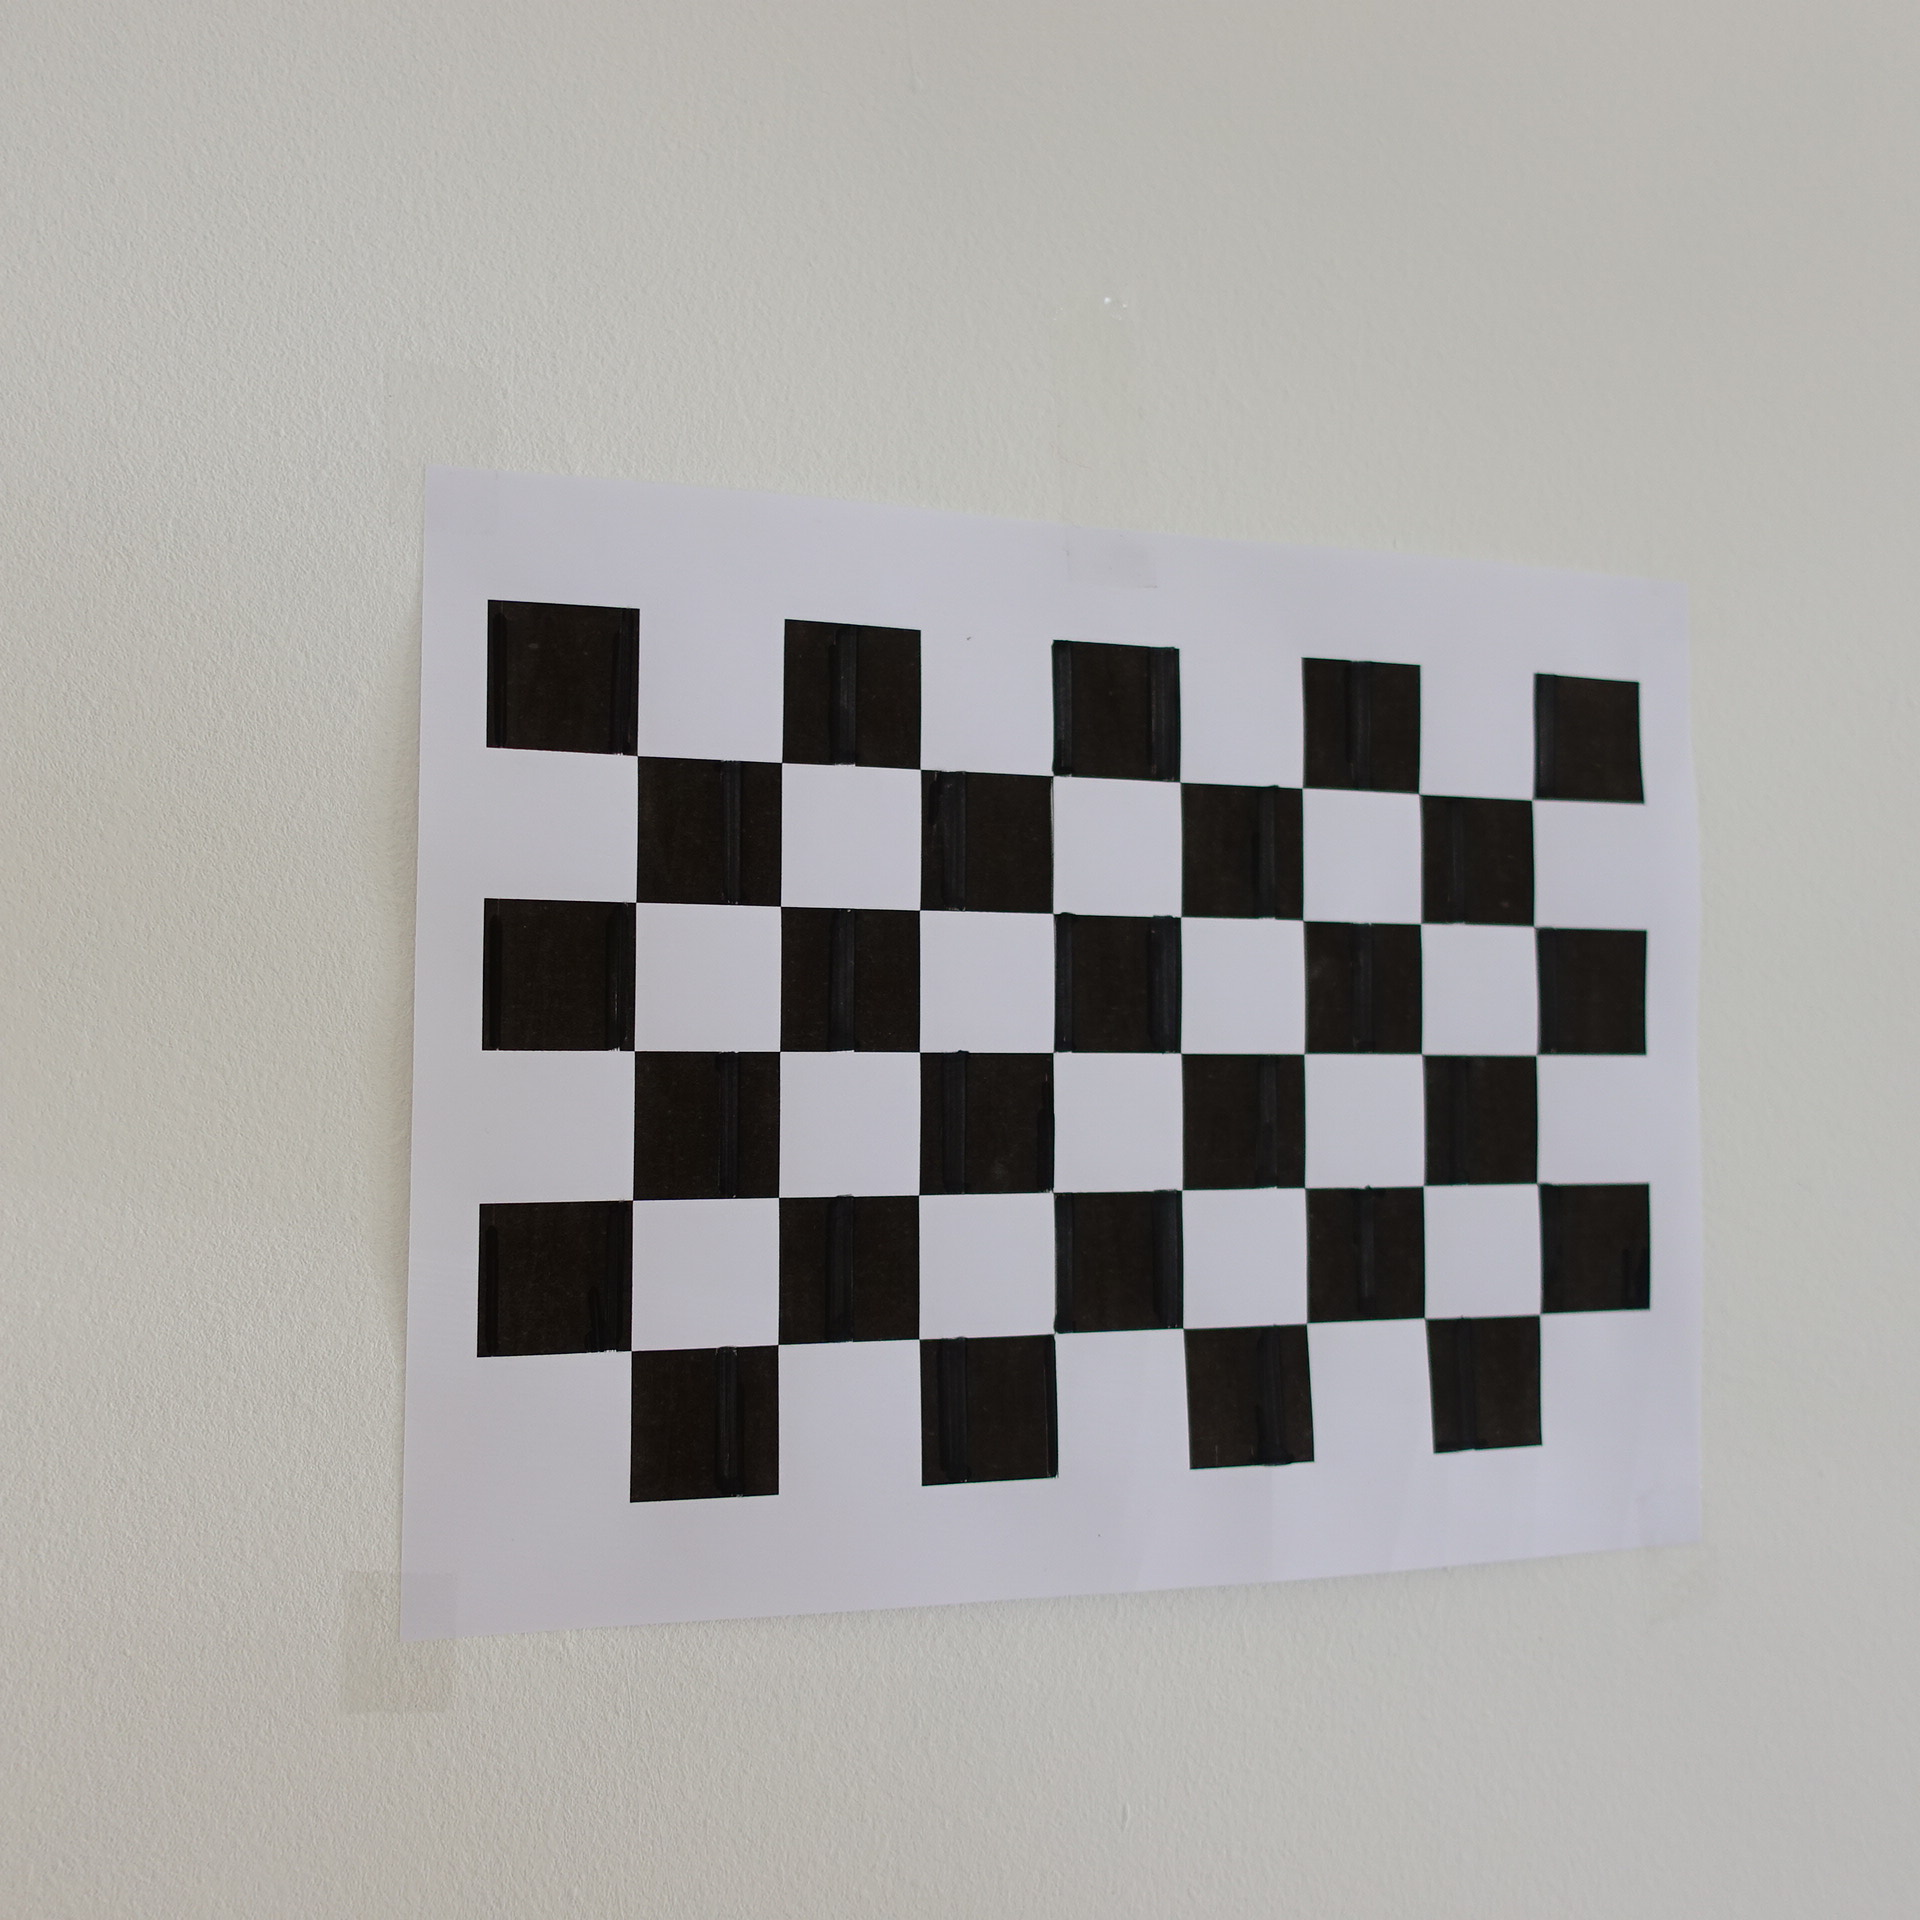

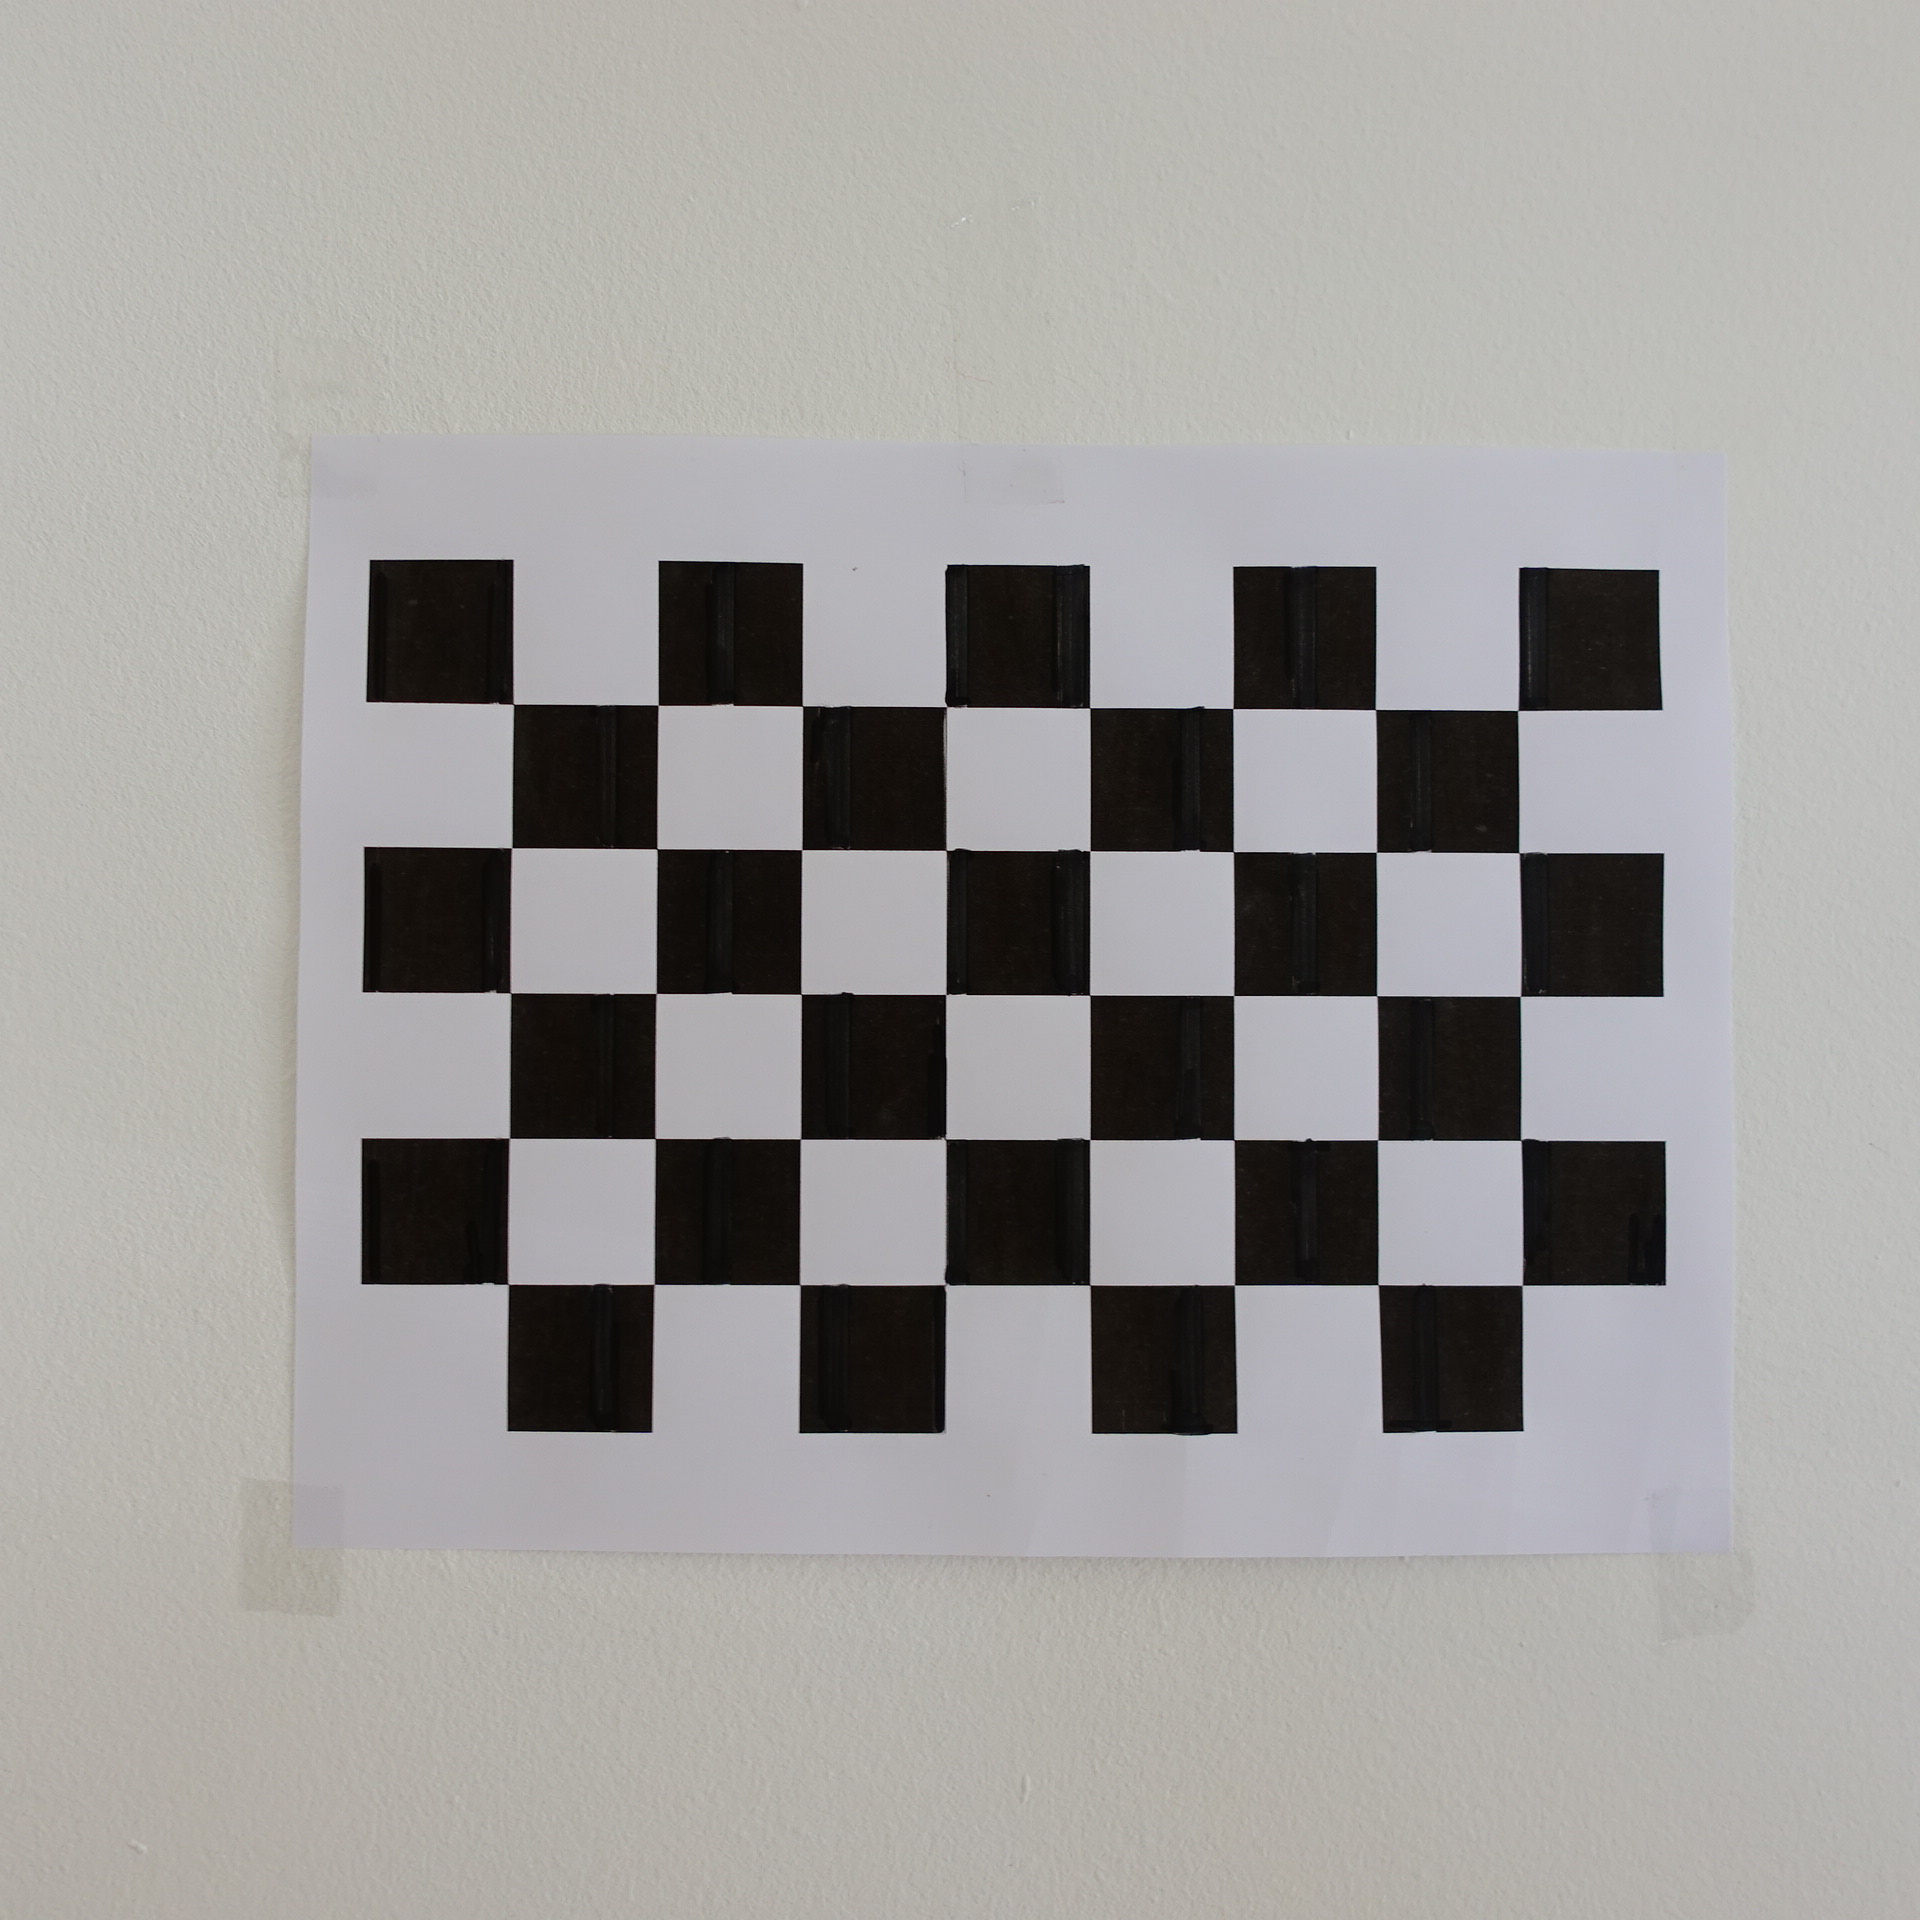

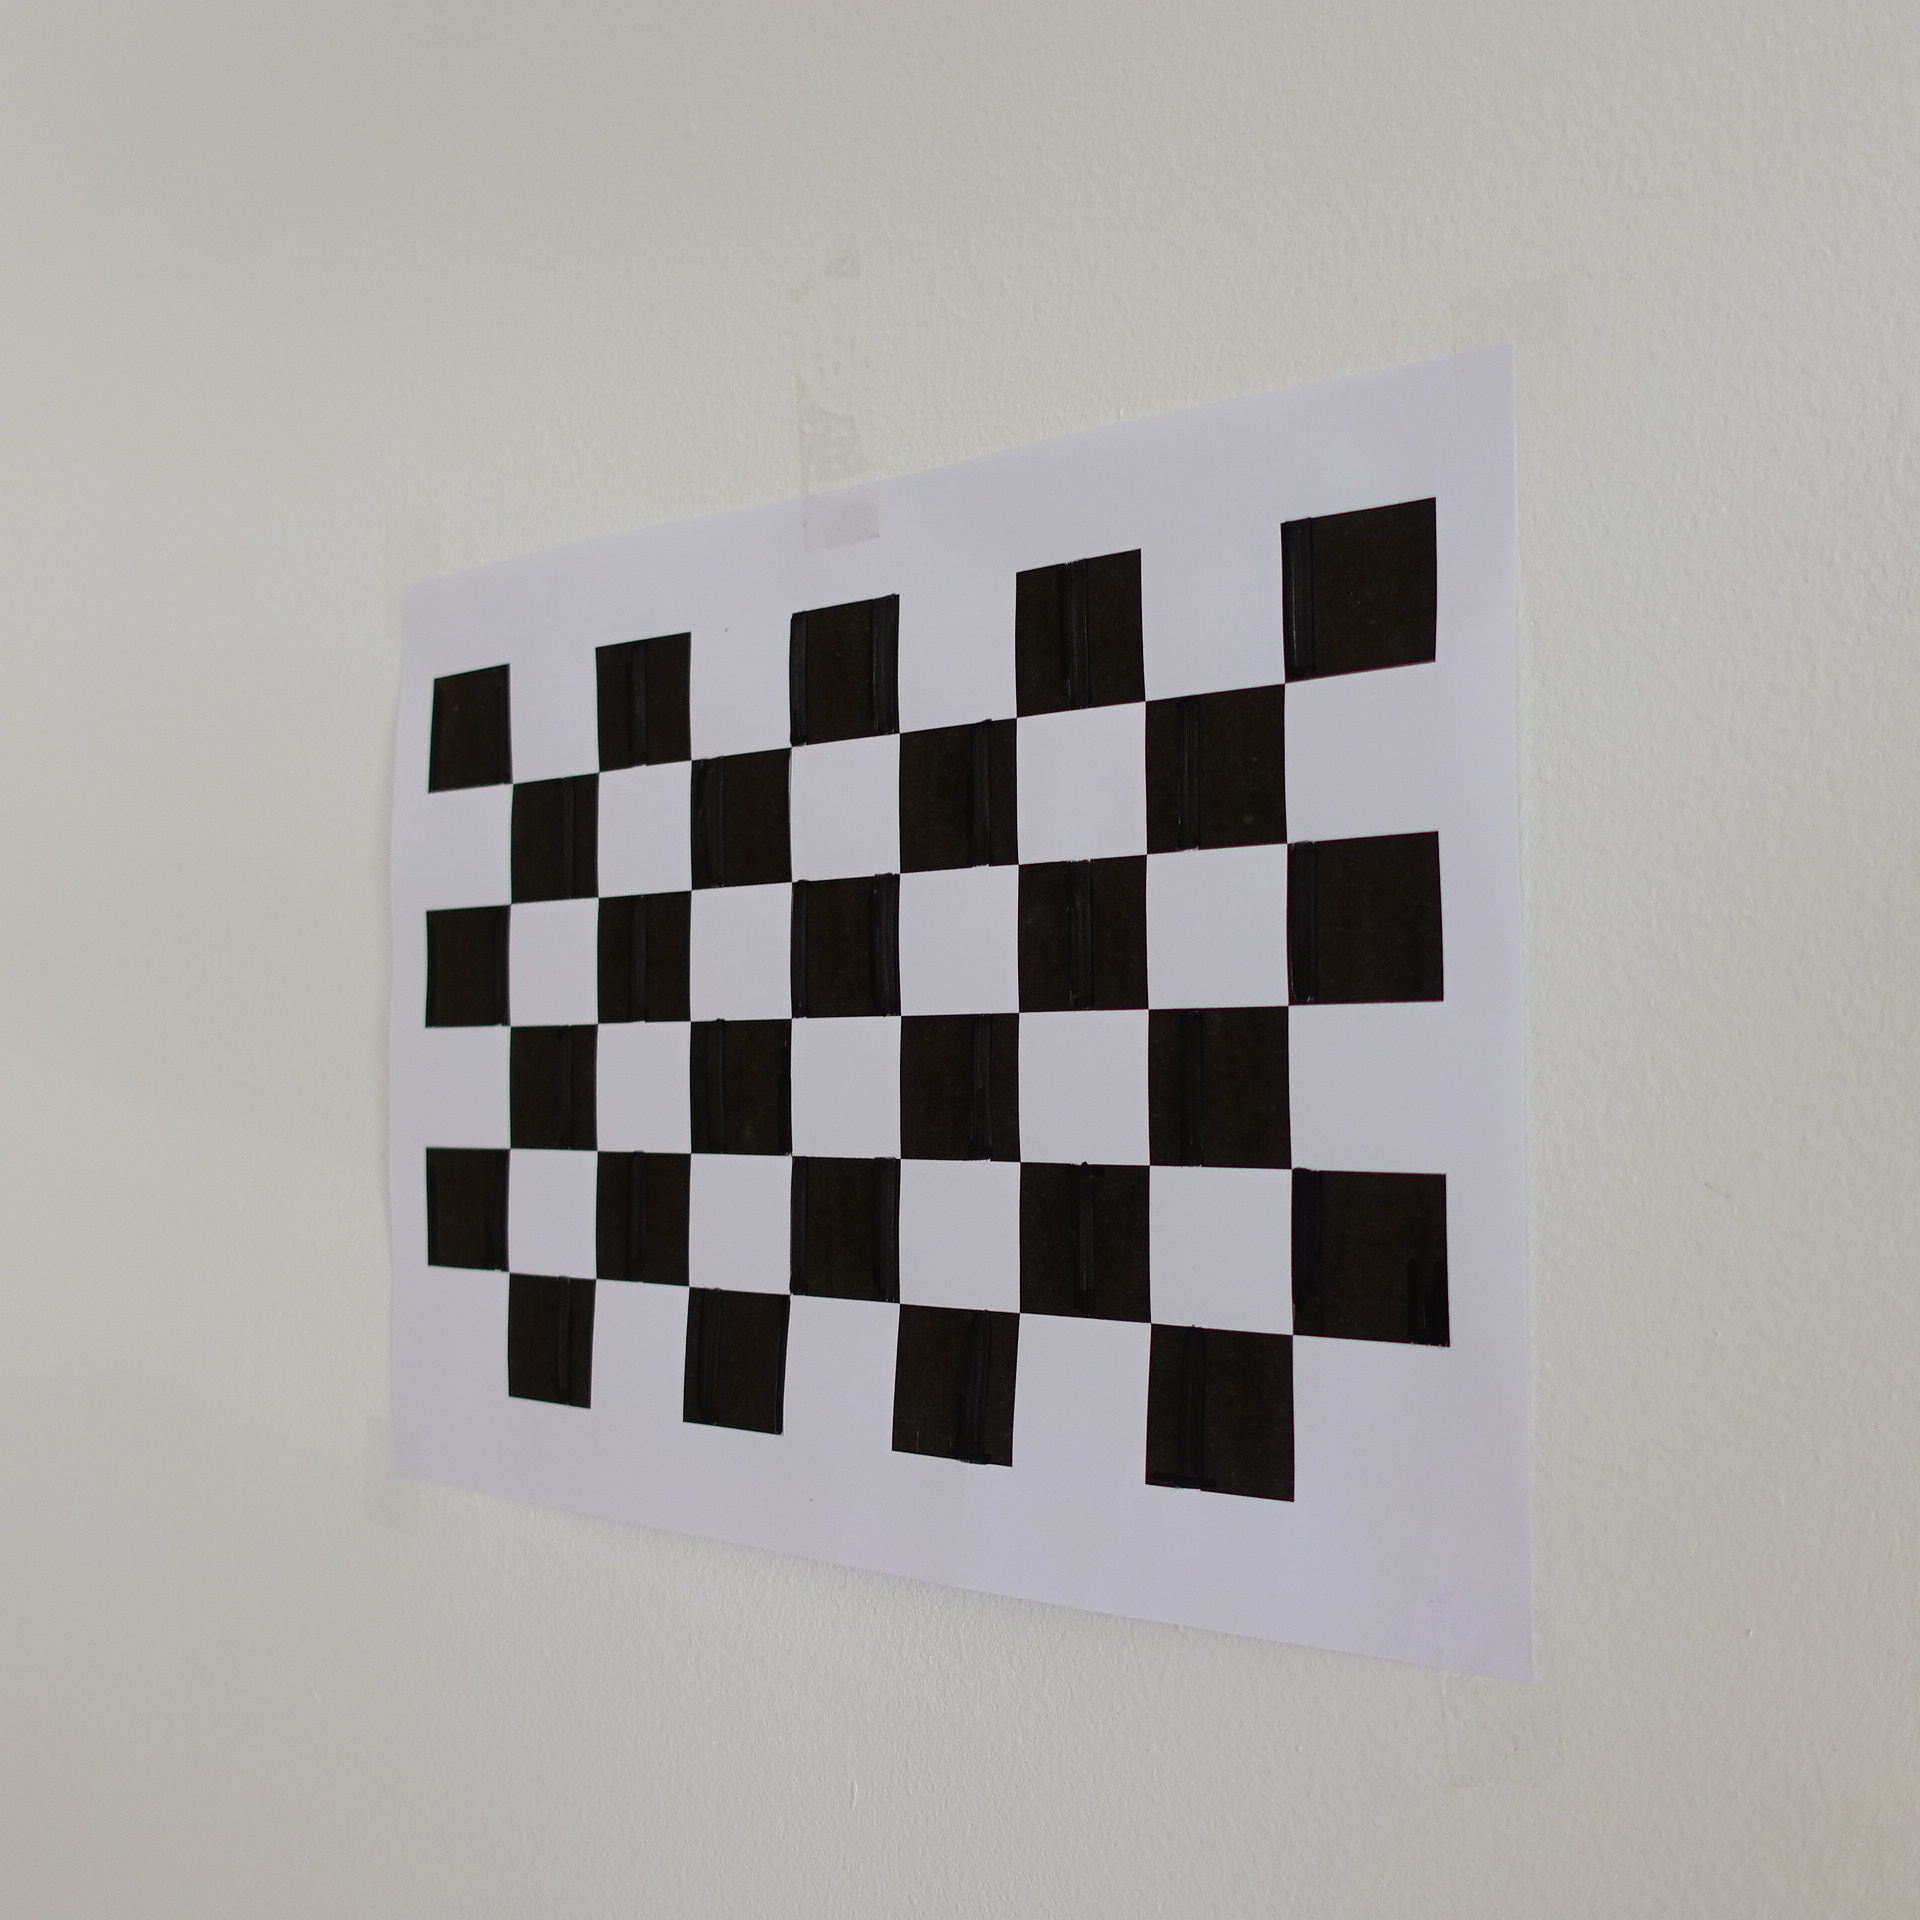

In [4]:
#calibrate the camera and get the instrinsic matrix mtx
ret, mtx, dist, rvecs, tvecs = calibrate_camera((5, 8), r'./imgs/*.jpg')

processing img ./imgs\DSC05198.JPG
corner detected
processing img ./imgs\DSC05199.JPG
corner detected
processing img ./imgs\DSC05200.JPG
corner detected
processing img ./imgs\DSC05201.JPG
corner detected
processing img ./imgs\DSC05202.JPG
corner detected
Camera matrix : 

[[1.98502421e+03 0.00000000e+00 9.57647938e+02]
 [0.00000000e+00 1.98556664e+03 9.68887799e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 

[[ 5.14342172e-02 -1.03802178e+00  1.03390309e-03 -8.94954625e-04
   6.30757796e+00]]
rvecs : 

(array([[-0.41939622],
       [-0.348797  ],
       [ 1.56025807]]), array([[-0.27865597],
       [-0.19881139],
       [ 1.56651143]]), array([[-0.03755325],
       [ 0.01020249],
       [ 1.57363863]]), array([[0.2372964 ],
       [0.29657694],
       [1.5582287 ]]), array([[0.44470836],
       [0.52469748],
       [1.49498018]]))
tvecs : 

(array([[ 4.69711297],
       [-1.53149328],
       [15.43475805]]), array([[ 4.50474981],
       [-1.33003589],
       [15.56870988

In [ ]:
#click on image to show the coordinance
def click_event(event, x, y, flags, params):

    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:

        # displaying the coordinates
        # on the Shell
        print('{},{},'.format(x,y))

        # displaying the coordinates
        # on the image window
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(x) + ',' +
                    str(y), (x,y), font,
                    1, (255, 0, 0), 2)
        cv2.imshow('image', img)
        
def show_coordinance(img_path):
    img = cv2.imread(img_path, 1)

    # displaying the image
    cv2.imshow('image', img)

    # setting mouse handler for the image
    # and calling the click_event() function
    cv2.setMouseCallback('image', click_event)

    # wait for a key to be pressed to exit
    cv2.waitKey(0)

    # close the window
    cv2.destroyAllWindows()

In [ ]:
#manually collect coordiance
show_coordinance(r'./rabbids/left.jpg')
show_coordinance(r'./rabbids/right.jpg')

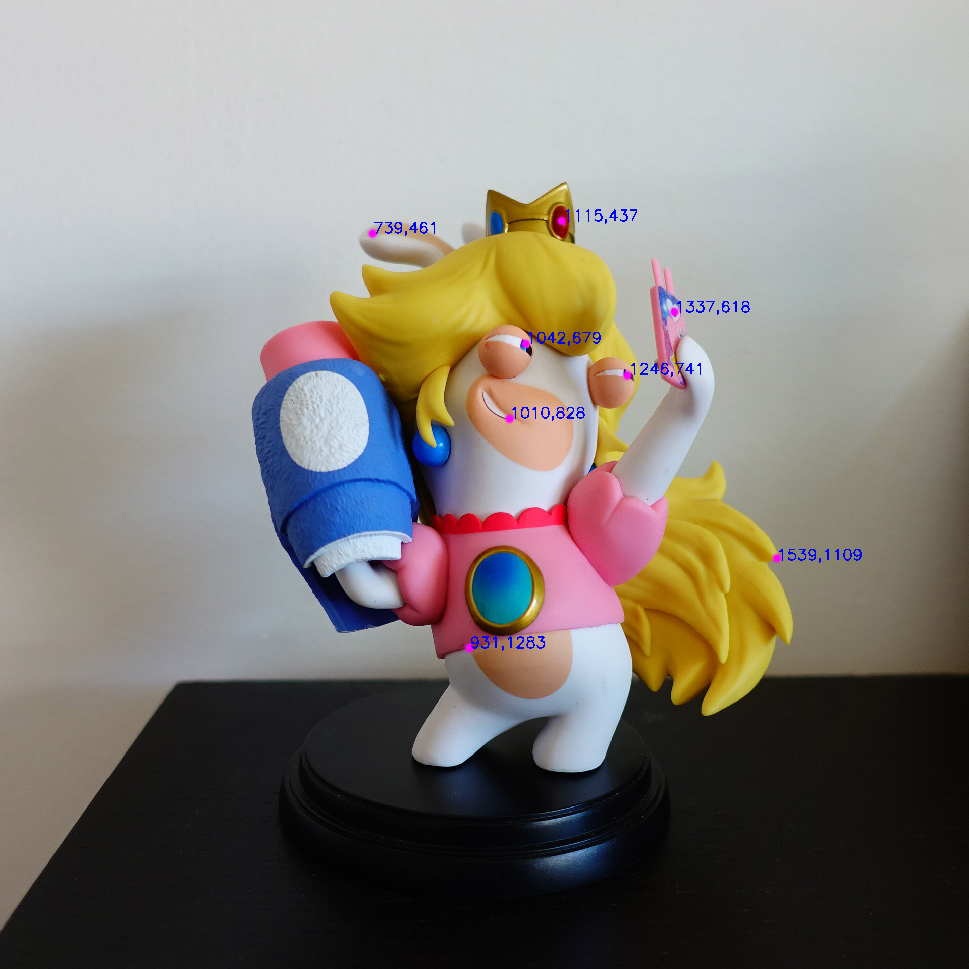

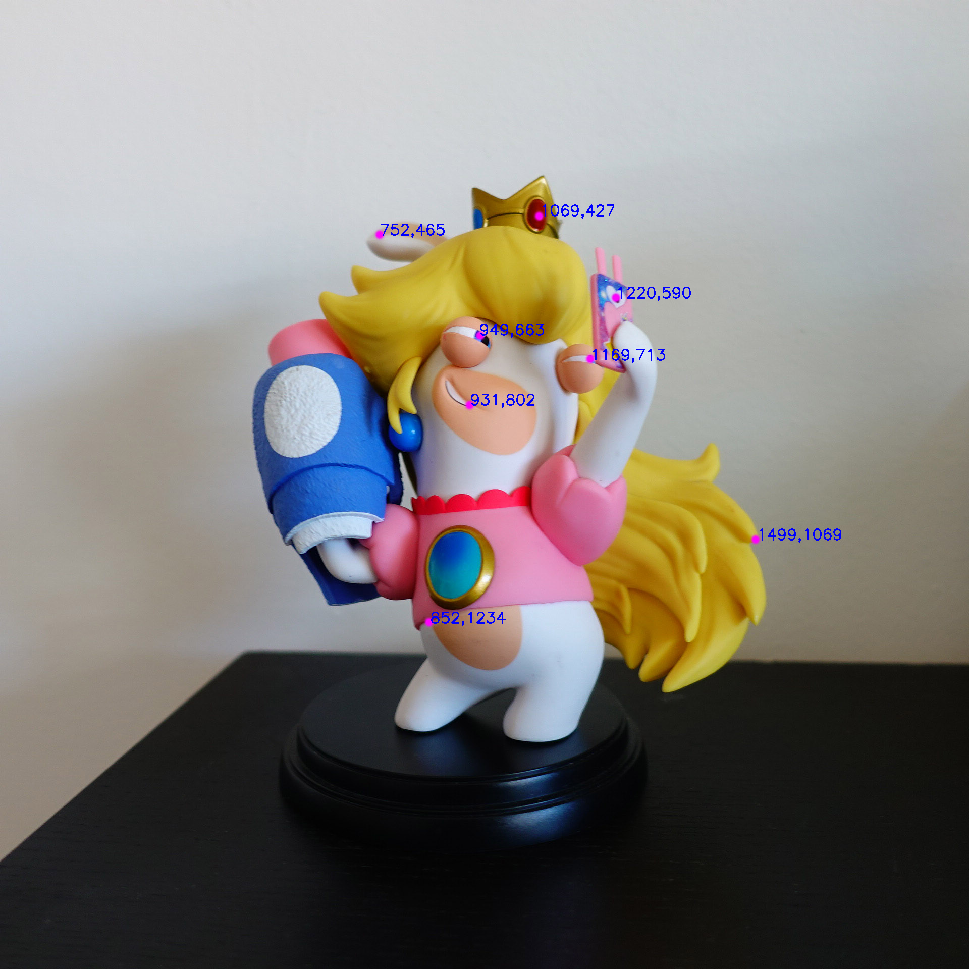

In [5]:
#manually identify 8 points from left and right images
# img1 x' y' x y im2
coordinates_mat = [[739, 461, 752, 465],
                   [1115, 437, 1069, 427],
                   [1042, 679, 949, 663],
                   [1337, 618, 1220, 590],
                   [1246, 741, 1169, 713],
                   [1010, 828, 931, 802],
                   [1539, 1109, 1499, 1069],
                   [931, 1283, 852, 1234]
                   ]

In [6]:
#normalize images, return T1 and T2 to denormalize later.
def normalize(points):
    # T1 acts on x,y to give x_hat
    # T2 acts on x'y' to give x'_hat
    n = len(points)
    img1_pts, img2_pts = [], []
    for a,b,c,d in points:
        img2_pts.append([a,b])
        img1_pts.append([c,d])
    sum1 = reduce(lambda x, y:  (x[0]+y[0], x[1]+y[1]), img1_pts)
    sum2 = reduce(lambda x, y:  (x[0]+y[0], x[1]+y[1]), img2_pts)

    mean1 = [val/n for val in sum1]
    mean2 = [val/n for val in sum2]

    s1 = (n*2)**0.5/(sum([((x-mean1[0])**2 + (y-mean1[1])**2)**0.5 for x,y in img1_pts]))
    s2 = (2*n)**0.5/(sum([((x-mean2[0])**2 + (y-mean2[1])**2)**0.5 for x,y in img2_pts]))

    T1 = np.array([[s1, 0, -mean1[0]*s1], [0, s1, -mean1[1]*s1], [0, 0, 1]])
    T2 = np.array([[s2, 0, -mean2[0]*s2], [0, s2, -mean2[1]*s2], [0, 0, 1]])

    points = [[T1 @ [c, d, 1], T2 @ [a,b,1]] for a,b,c,d in points]
    points = [[l[0], l[1], r[0], r[1]] for l,r in points]
    return points, T1, T2

In [7]:
def eight_point(mat,t1,t2):
    A = np.zeros((len(mat),9))
    # img1 x' y' x y im2
    for i in range(len(mat)):
        A[i][0] = mat[i][0]*mat[i][2]
        A[i][1] = mat[i][1]*mat[i][2]
        A[i][2] = mat[i][2]
        A[i][3] = mat[i][0]*mat[i][3]
        A[i][4] = mat[i][1]*mat[i][3]
        A[i][5] = mat[i][3]
        A[i][6] = mat[i][0]
        A[i][7] = mat[i][1]
        A[i][8] = 1.0
    #use svd to decompose A to find fundamental matrix f_mat
    _,_,v = np.linalg.svd(A)
    f_mat = np.reshape(v.T[:, 8], (3, 3)).T

    # Enforce rank(F) = 2
    u,d,v = np.linalg.svd(f_mat)
    f_mat = u @ np.diag(np.array([d[0], d[1], 0])) @ v

    #denormalize
    f_mat = t2.T @ f_mat @ t1
    return f_mat

In [8]:
#decompose essential matrix to get translation and rotation
def e_to_tr(e_mat):
    u, d, v = np.linalg.svd(e_mat)
    w = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)
    r = u.dot(w).dot(v)
    t = u[:, 2]
    return t, r

In [9]:
#normalize coordinates
norm_points, t1, t2 = normalize(coordinates_mat)
#use normalized corrdinates to find fundamental matrix
f_mat = eight_point(norm_points, t1, t2)
#transform fundamental matrix to essential matrix
e_mat = mtx.T @ f_mat @ mtx
#decompose essential matrix to get translation, and rotation
t, r = e_to_tr(e_mat)
#use openCV to confirm the result
R1, R2, T = cv2.decomposeEssentialMat(e_mat)

In [10]:
print('fundamental matrix:')
print(f_mat)
print('essential matrix:')
print(e_mat)
print('translation:')
print(t)
print('rotation:')
print(r)
print('transaltion from openCV:')
print(T)
print('rotation from openCV:')
print(R1)


fundamental matrix:
[[ 1.71759515e-09 -8.47328107e-07  3.88402782e-04]
 [ 1.06759068e-06  4.26948879e-08 -2.06694297e-03]
 [-5.20141767e-04  1.86192704e-03  1.36703572e-01]]
essential matrix:
[[ 0.00676788 -3.33965717 -0.85538312]
 [ 4.20779959  0.16832352 -1.99192125]
 [ 1.02403164  2.16794407  0.05793269]]
translation:
[ 0.52609652 -0.20189311  0.82611235]
rotation:
[[-0.54666693 -0.22476907  0.80661895]
 [-0.1797315  -0.90935039 -0.37520456]
 [ 0.81783363 -0.35008676  0.4567137 ]]
transaltion from openCV:
[[ 0.52609652]
 [-0.20189311]
 [ 0.82611235]]
rotation from openCV:
[[-0.54666693 -0.22476907  0.80661895]
 [-0.1797315  -0.90935039 -0.37520456]
 [ 0.81783363 -0.35008676  0.4567137 ]]


In [ ]:
#manually collect coordiance for 3d (different from 8 points)
show_coordinance(r'./rabbids/3d_left.jpg')
show_coordinance(r'./rabbids/3d_right.jpg')

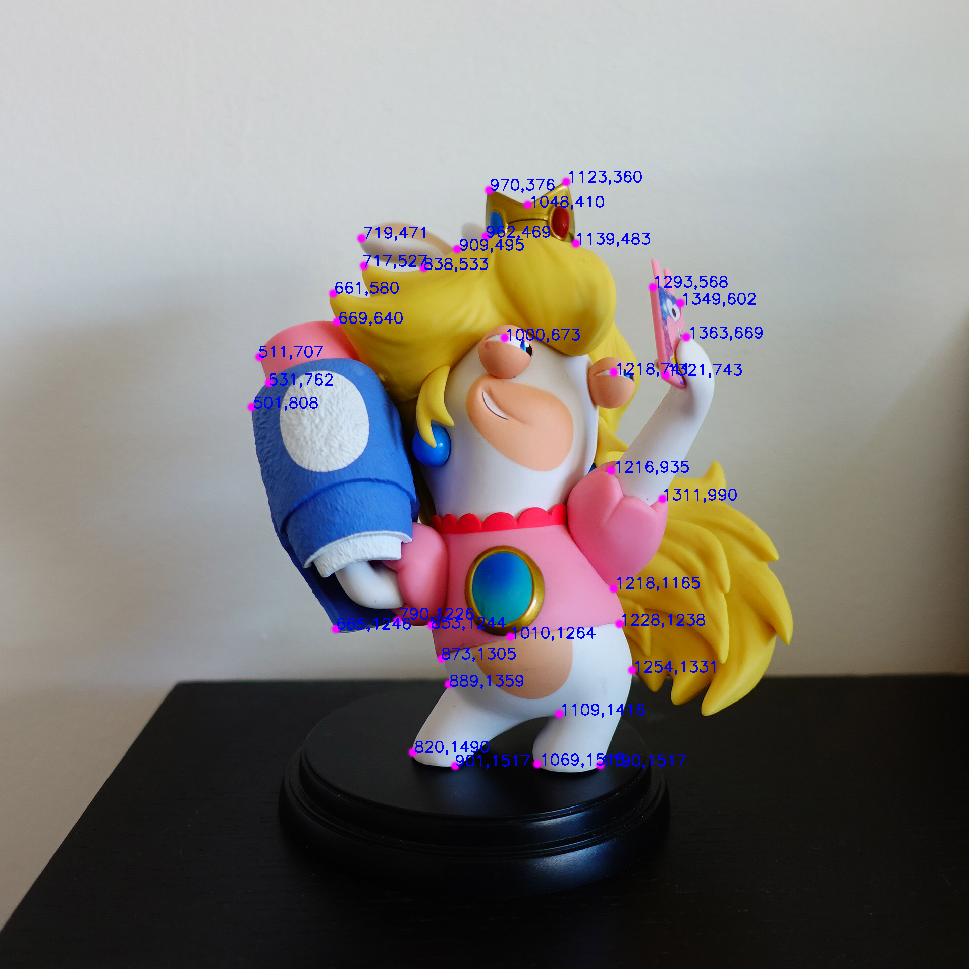

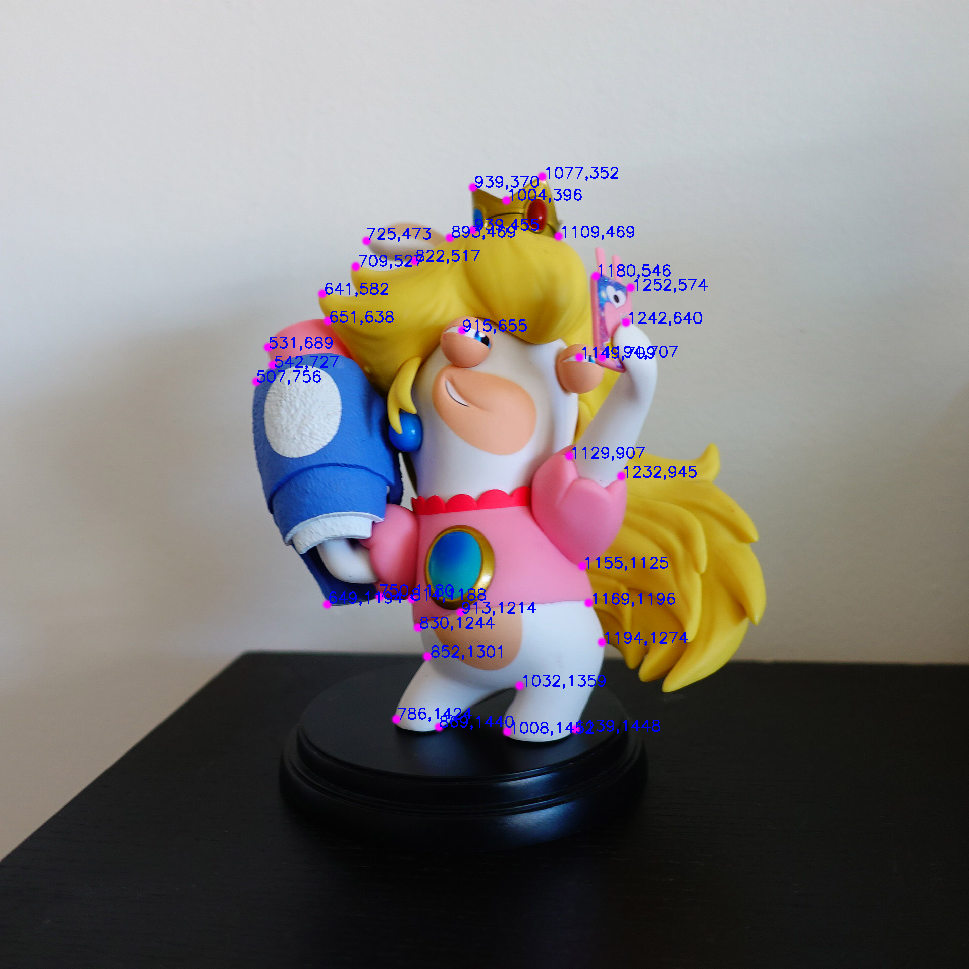

In [11]:
left_cor = np.array([1139, 483,
                     1123, 360,
                     1048, 410,
                     970, 376,
                     962, 469,
                     909, 495,
                     719, 471,
                     838, 533,
                     717, 527,
                     661, 580,
                     669, 640,
                     511, 707,
                     531, 762,
                     501, 808,
                     665, 1246,
                     790, 1226,
                     853, 1244,
                     873, 1305,
                     889, 1359,
                     820, 1490,
                     901, 1517,
                     1109, 1416,
                     1069, 1515,
                     1190, 1517,
                     1254, 1331,
                     1228, 1238,
                     1218, 1165,
                     1311, 990,
                     1363, 669,
                     1349, 602,
                     1293, 568,
                     1321, 743,
                     1216, 935,
                     1218, 741,
                     1000, 673,
                     1010, 1264]).reshape(-1, 2)

right_cor = np.array([1109, 469,
                      1077, 352,
                      1004, 396,
                      939, 370,
                      939, 455,
                      893, 469,
                      725, 473,
                      822, 517,
                      709, 527,
                      641, 582,
                      651, 638,
                      531, 689,
                      542, 727,
                      507, 756,
                      649, 1194,
                      750, 1180,
                      814, 1188,
                      830, 1244,
                      852, 1301,
                      786, 1424,
                      869, 1440,
                      1032, 1359,
                      1008, 1452,
                      1139, 1448,
                      1194, 1274,
                      1169, 1196,
                      1155, 1125,
                      1232, 945,
                      1242, 640,
                      1252, 574,
                      1180, 546,
                      1194, 707,
                      1129, 907,
                      1149, 709,
                      915, 655,
                      913, 1214, ]).reshape(-1, 2)

In [12]:
#use essential matrix to find projective matrix for right camera
def camera2(E):
    U,S,V = np.linalg.svd(E)
    m = S[:2].mean()
    E = U.dot(np.array([[m,0,0], [0,m,0], [0,0,0]])).dot(V)
    U,S,V = np.linalg.svd(E)
    W = np.array([[0,-1,0], [1,0,0], [0,0,1]])

    if np.linalg.det(U.dot(W).dot(V))<0:
        W = -W

    M2s = np.zeros([3,4,4])
    M2s[:,:,0] = np.concatenate([U.dot(W).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,1] = np.concatenate([U.dot(W).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,2] = np.concatenate([U.dot(W.T).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,3] = np.concatenate([U.dot(W.T).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    return M2s

In [13]:
#triangulate a set of 2D coordinates in the image to a set of 3D points
#I use MSE to caculate the projection error
def triangulate(pts1, pts2, mtx, m2):
    m1 = np.hstack((np.identity(3), np.zeros(3)[:, np.newaxis]))
    C1 = mtx.dot(m1)
    C2 = mtx.dot(m2)
    w, err = 0, 0
    N = pts1.shape[0]
    A = np.zeros((4, 4))
    e = 0  # error
    P = np.zeros((N, 3))

    for i in range(N):
        A[0,:] = (pts1[i,1]*C1[2,:])-C1[1,:]
        A[1,:] = -(pts1[i,0]*C1[2,:])+C1[0,:]
        A[2,:] = (pts2[i,1]*C2[2,:])-C2[1,:]
        A[3,:] = -(pts2[i,0]*C2[2,:])+C2[0,:]
        u,s,vh = np.linalg.svd(A)
        X = vh[-1,:]
        X = X/X[3]
        x = C1@X.T
        x = x/x[2]
        x_ = C2@X.T
        x_ = x_/x_[2]
        e += (np.linalg.norm(pts1[i]-x[0:2])**2 + np.linalg.norm(pts2[i]-x_[0:2])**2)/N
        P[i,:] = X[0:3]

    return P, e

In [14]:
#iterate through possible M2s to find best M2 with minimal error
def findM2(pts1, pts2, e_mat, mtx):
    M1 = np.hstack((np.eye(3),np.zeros((3,1))))
    #print(M1)
    C1 = mtx@M1
    M2s = camera2(e_mat)
    e = 20000
    M2_best = None
    C2_best = None
    P_best = None

    for i in range(M2s.shape[-1]): #essentially 4 times
        M2 = M2s[:,:,i]
        C2 = mtx@M2
        P_trial, err = triangulate(pts1, pts2, mtx, M2)
        print(err)
        if (np.all(P_trial[:,-1]>0) and err<e):
            e = err
            M2_best = M2
            C2_best = C2
            P_best = P_trial

    print("Best Error : ",e)
    return M2_best, C2_best, P_best

In [15]:
M2_best, C2_best, P_best = findM2(left_cor, right_cor, e_mat, mtx)
P, err = triangulate(left_cor, right_cor, mtx, M2_best)

16778.164879264008
16778.164879264008
17028.104588932416
17028.104588932416
Best Error :  16778.164879264008


In [18]:
#describe the projection to set x,y,z axes
pd.DataFrame(P).describe()

0          1          2
count  36.000000  36.000000  36.000000
mean   -0.007114  -0.049274   0.773916
std     0.097977   0.139885   0.033248
min    -0.196338  -0.225423   0.728144
25%    -0.086069  -0.170973   0.745967
50%     0.003499  -0.109331   0.764888
75%     0.073604   0.078468   0.803676
max     0.151454   0.183067   0.841185

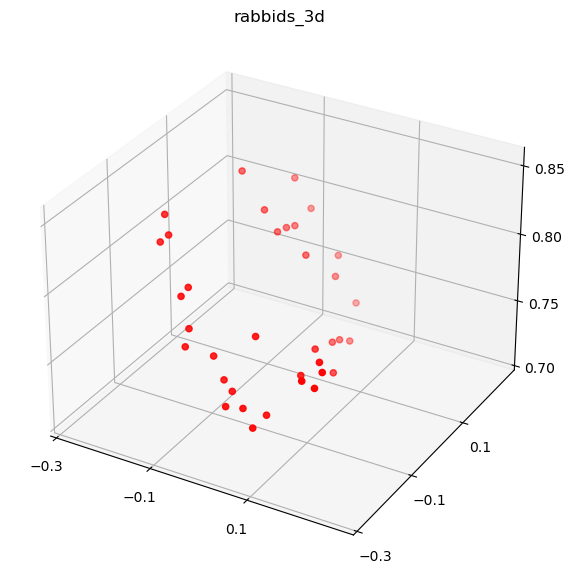

In [19]:
# 3D plot - gfg
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ticks_x = np.arange(-0.3, 0.3, 0.2)
ax.set_xticks(ticks_x)
ticks_y = np.arange(-0.3, 0.3, 0.2)
ax.set_yticks(ticks_y)
ticks_z = np.arange(0.70, 0.86, 0.05)
ax.set_zticks(ticks_z)
ax.set_xlim3d(-0.3,0.3)
ax.set_ylim3d(-0.3,0.3)
ax.set_zlim3d(0.7,0.86)

ax.scatter3D(P[:,0], P[:,1], P[:,2], color = "red")
plt.title("rabbids_3d")
plt.show()